# Movie Sequel Budget Predictor

## Introduction

Purpose of this notebook is to ask the question: With the data at hand, how well can we predict the budget of a sequel? This has a more weighted business case that simply predicting the sequel movie returns as production houses must know how to allocated resources for its subsequent film either for a sequel or within a franchise. 

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from pprint import pprint

from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.linear_model import ElasticNet,BayesianRidge,HuberRegressor
from sklearn.linear_model import ARDRegression,SGDRegressor

import statsmodels.api as sm

from sklearn.model_selection import KFold,train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler

import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import mean_squared_error,make_scorer,r2_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

%config InlineBackend.figure_format='retina'

## Constants

In [2]:
# Set percent cut-off
# Percent cut-off is defined as [(Gross Seq - Gross Org)/min(Gross Seq, Gross Org)]*100
pct_cut_off = 2e3

test_size = 0.20

seed = 1234

## Load Data File(s)

In [3]:
data_path = './data/'

file_all = 'movies_with_sequels_final_cleaned.csv'
file_org = 'movies_with_originals_only_final_cleaned.csv'
file_seq = 'movies_with_sequels_only_final_cleaned.csv'

df_all = pd.read_csv(data_path + file_all)
df_org = pd.read_csv(data_path + file_org)
df_seq = pd.read_csv(data_path + file_seq)

df_all['Release Date'] = pd.to_datetime(df_all['Release Date'])
df_org['Release Date'] = pd.to_datetime(df_org['Release Date'])
df_seq['Release Date'] = pd.to_datetime(df_seq['Release Date'])



In [4]:
# Get time between original and sequel
def diff_rel_dates(data_org,data_seq,delta_type):
    
    delta_time = (data_seq['Release Date'] - data_org['Release Date'])/np.timedelta64(1, delta_type)
    
    neg_delta = delta_time[delta_time < 0]
    
    if neg_delta is not None:
        print('No negative difference')
    else:
        print('There are negative time(s) between sequel and original. Please check!')

    return delta_time

In [5]:
# Set years as the difference between sequel and original
diff_type = 'Y'

diff_time = diff_rel_dates(df_org,df_seq,diff_type)

No negative difference


## Feature Engineering

### Select Target

In [6]:
# Attach the target variable, budget from sequel to df_org dataframe and rescale
df_org['target'] = np.log(df_seq['Budget'])


### Remove Outliers (Budget Percentages)

Based on the EDA portion of this study (Notebook 04), I noticed that Budget Sequel vs. Budget Original contained several outliers. They were notably:

1. Mallrats and Chasing Amy
2. Blair Witch Project 1 & 2
3. Fantasia and Fantasia 2000
...

and many others. The systematic way to remove outliers is to consider a percentage bandwidth. If more funds are allocated to a sequel either because its sequel out-performed its original (or under-performed) say for example above or below 1,000%, then we will remove this movies. The user has control of the bandwidth. Note, the narrower the bandwidth the more observations you remove and thus you end-up with less data to train and test.

In [7]:
# Let's add the runtime for the sequel

df_org['RuntimeSeq'] = df_seq['Runtime (mins)']

In [8]:
def remove_outliers_budgets(data_org,data_seq,pct_cut_off):

    df_temp = data_org[['Title']]
    df_temp['Budget Original'] = data_org['Budget']
    df_temp['Budget Sequel'] = df_seq['Budget']

    # Calculate percentage differces
    df_temp['MinBudget_SeqOrg'] =  df_temp[['Budget Original', 'Budget Sequel']].min(axis=1)
    df_temp['BudgetPercentDiff'] = round((df_temp['Budget Sequel'] - df_temp['Budget Original'])/df_temp['MinBudget_SeqOrg']*100,2)
    df_temp['AbsBudgetPercentDiff'] = round(np.abs(df_temp['Budget Sequel'] - df_temp['Budget Original'])/df_temp['MinBudget_SeqOrg']*100,2)

    df_mov_pct_cut = df_temp[(df_temp['AbsBudgetPercentDiff'] > pct_cut_off) | (df_temp['AbsBudgetPercentDiff'] < -1*pct_cut_off)]

    # Remove suggested outliers that lay outside of the bandwidth
    data_org = data_org.drop(df_mov_pct_cut.index)
    data_org = data_org.reset_index(drop=True)
    
    print('\nRemoved: ',len(df_mov_pct_cut),'observations with, {:,.0f}%, cut-off'.format(pct_cut_off))
        
    print()
    print()
    
    return data_org,df_mov_pct_cut

In [9]:
df_org,df_filetered_movies = remove_outliers_budgets(df_org,df_seq,pct_cut_off)

# Assign the target variable
y = df_org['target']

df_filetered_movies.sort_values(by='AbsBudgetPercentDiff',ascending=False)


Removed:  8 observations with, 2,000%, cut-off




,Title,Budget Original,Budget Sequel,MinBudget_SeqOrg,BudgetPercentDiff,AbsBudgetPercentDiff
317,Blair Witch Project,60000.0,15000000.0,60000.0,24900.00,24900.00
315,Clerks (1994),27000.0,5000000.0,27000.0,18418.52,18418.52
497,Fantasia (1940),2280000.0,80000000.0,2280000.0,3408.77,3408.77
365,El Mariachi (1992),208000.0,7000000.0,208000.0,3265.38,3265.38
322,Bad Lieutenant (1992),1000000.0,25000000.0,1000000.0,2400.00,2400.00
404,Mallrats (1995),6000000.0,250000.0,250000.0,-2300.00,2300.00
449,Mary Poppins (1964),6000000.0,130000000.0,6000000.0,2066.67,2066.67
448,Bhoothnath,210000.0,4522000.0,210000.0,2053.33,2053.33


In [10]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Title            531 non-null    object        
 1   url              531 non-null    object        
 2   IMDB Score       531 non-null    float64       
 3   Metacritic       498 non-null    float64       
 4   Runtime (mins)   531 non-null    int64         
 5   Budget           531 non-null    float64       
 6   Opening Weekend  468 non-null    float64       
 7   Gross USA        500 non-null    float64       
 8   Gross World      531 non-null    float64       
 9   Release Date     531 non-null    datetime64[ns]
 10  Rating           531 non-null    object        
 11  Genres           531 non-null    object        
 12  Country          531 non-null    object        
 13  target           531 non-null    float64       
 14  RuntimeSeq       531 non-null    int64    

### Drop Features

In [11]:
cols_to_drop = ['Title','url','Metacritic','Opening Weekend', 'Gross USA','Country','target']

# Add box office returns of its sequel

df_org['GrossSeq'] = df_seq['Gross World']

df_org.drop(cols_to_drop,axis=1,inplace=True)

In [12]:
df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,Release Date,Rating,Genres,RuntimeSeq,GrossSeq
0,7.3,121,139000000.0,8.250250e+08,2002-05-03,PG-13,Action Adventure Sci-Fi,127,7.889765e+08
1,8.7,136,63000000.0,4.653438e+08,1999-03-31,R,Action Sci-Fi,138,7.418465e+08
2,8.8,178,93000000.0,8.878328e+08,2001-12-19,PG-13,Action Adventure Drama,179,9.512081e+08
3,8.9,201,94000000.0,1.142219e+09,2003-12-17,PG-13,Adventure Drama Fantasy,169,1.017004e+09
4,7.8,161,225000000.0,9.583669e+08,2013-12-13,PG-13,Adventure Fantasy,144,9.560198e+08


### One-Hot-Encoding

In [13]:
df_rating = pd.get_dummies(df_org['Rating'],prefix = 'r', drop_first=False)

df_rating.head()

,r_G,r_PG,r_PG-13,r_R
0,0,0,1,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [14]:
# Nice tip from Jeremy Cunningham
df_genres_temp = df_org.Genres.str.split(' ', expand=True).stack()

df_genres = pd.get_dummies(df_genres_temp, prefix='g').groupby(level=0).max()

df_genres = df_genres.reset_index()

df_genres.drop(['index'],axis=1,inplace=True)

df_genres.head()

,g_Action,g_Adventure,g_Animation,g_Biography,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Family,g_Fantasy,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Combine the two
df_ratings_genres = pd.concat([df_rating, df_genres], axis=1)

df_ratings_genres.head()

,r_G,r_PG,r_PG-13,r_R,g_Action,g_Adventure,g_Animation,g_Biography,g_Comedy,g_Crime,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dates

In [16]:
df_org['deltaYears'] = diff_time

df_org['MonthOrg'] = df_org['Release Date'].dt.month
df_org['DOWOrg']   = df_org['Release Date'].dt.dayofweek
df_org['DayOrg']   = df_org['Release Date'].dt.day

df_org['MonthSeq'] = df_seq['Release Date'].dt.month
df_org['DOWSeq']   = df_seq['Release Date'].dt.dayofweek
df_org['DaySeq']   = df_seq['Release Date'].dt.day

In [17]:
df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,Release Date,Rating,Genres,RuntimeSeq,GrossSeq,deltaYears,MonthOrg,DOWOrg,DayOrg,MonthSeq,DOWSeq,DaySeq
0,7.3,121,139000000.0,8.250250e+08,2002-05-03,PG-13,Action Adventure Sci-Fi,127,7.889765e+08,2.160209,5,4,3,6,2,30
1,8.7,136,63000000.0,4.653438e+08,1999-03-31,R,Action Sci-Fi,138,7.418465e+08,4.123288,3,2,31,5,3,15
2,8.8,178,93000000.0,8.878328e+08,2001-12-19,PG-13,Action Adventure Drama,179,9.512081e+08,0.996598,12,2,19,12,2,18
3,8.9,201,94000000.0,1.142219e+09,2003-12-17,PG-13,Adventure Drama Fantasy,169,1.017004e+09,8.994025,12,2,17,12,4,14
4,7.8,161,225000000.0,9.583669e+08,2013-12-13,PG-13,Adventure Fantasy,144,9.560198e+08,1.010288,12,4,13,12,2,17


In [18]:
df_rel_time = df_org[['MonthOrg','DOWOrg','DayOrg']]

df_org.drop(['Rating','Genres', 'Release Date'], axis=1, inplace=True)

df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,RuntimeSeq,GrossSeq,deltaYears,MonthOrg,DOWOrg,DayOrg,MonthSeq,DOWSeq,DaySeq
0,7.3,121,139000000.0,8.250250e+08,127,7.889765e+08,2.160209,5,4,3,6,2,30
1,8.7,136,63000000.0,4.653438e+08,138,7.418465e+08,4.123288,3,2,31,5,3,15
2,8.8,178,93000000.0,8.878328e+08,179,9.512081e+08,0.996598,12,2,19,12,2,18
3,8.9,201,94000000.0,1.142219e+09,169,1.017004e+09,8.994025,12,2,17,12,4,14
4,7.8,161,225000000.0,9.583669e+08,144,9.560198e+08,1.010288,12,4,13,12,2,17


In [19]:
df_rel_time = df_rel_time.reset_index(drop=True)
df_rel_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   MonthOrg  531 non-null    int64
 1   DOWOrg    531 non-null    int64
 2   DayOrg    531 non-null    int64
dtypes: int64(3)
memory usage: 12.6 KB


### Numeric Columns

In [20]:
# Transform Budget and Gross into Log numbers
df_org['LogBudgetOrg'] = np.log(df_org['Budget'])
df_org['LogGrossOrg']  = np.log(df_org['Gross World'])
df_org['LogGrossSeq']  = np.log(df_org['GrossSeq'])

#df_org.drop(['Budget','GrossSeq'], axis=1, inplace=True)

#df_org.rename(columns = {'Runtime (mins)':'Runtime'}, inplace = True)

df_org.head()

,IMDB Score,Runtime (mins),Budget,Gross World,RuntimeSeq,GrossSeq,deltaYears,MonthOrg,DOWOrg,DayOrg,MonthSeq,DOWSeq,DaySeq,LogBudgetOrg,LogGrossOrg,LogGrossSeq
0,7.3,121,139000000.0,8.250250e+08,127,7.889765e+08,2.160209,5,4,3,6,2,30,18.749984,20.530924,20.486247
1,8.7,136,63000000.0,4.653438e+08,138,7.418465e+08,4.123288,3,2,31,5,3,15,17.958645,19.958287,20.424653
2,8.8,178,93000000.0,8.878328e+08,179,9.512081e+08,0.996598,12,2,19,12,2,18,18.348110,20.604294,20.673243
3,8.9,201,94000000.0,1.142219e+09,169,1.017004e+09,8.994025,12,2,17,12,4,14,18.358805,20.856239,20.740126
4,7.8,161,225000000.0,9.583669e+08,144,9.560198e+08,1.010288,12,4,13,12,2,17,19.231611,20.680741,20.678289


In [21]:
df_org.drop(['Budget','GrossSeq','Gross World'], axis=1, inplace=True)

df_org.rename(columns = {'Runtime (mins)':'RuntimeOrg'}, inplace = True)
df_org.rename(columns = {'IMDB Score':'IMDB Score Org'}, inplace = True)

df_org.head()

,IMDB Score Org,RuntimeOrg,RuntimeSeq,deltaYears,MonthOrg,DOWOrg,DayOrg,MonthSeq,DOWSeq,DaySeq,LogBudgetOrg,LogGrossOrg,LogGrossSeq
0,7.3,121,127,2.160209,5,4,3,6,2,30,18.749984,20.530924,20.486247
1,8.7,136,138,4.123288,3,2,31,5,3,15,17.958645,19.958287,20.424653
2,8.8,178,179,0.996598,12,2,19,12,2,18,18.348110,20.604294,20.673243
3,8.9,201,169,8.994025,12,2,17,12,4,14,18.358805,20.856239,20.740126
4,7.8,161,144,1.010288,12,4,13,12,2,17,19.231611,20.680741,20.678289


## Design Matrix & Modeling


I will test several options here to see which generates the best R^2 Score

1. IMDB Score, Runtime Original and Sequel, deltaYears, LogBudget, LogGross, and LogGrossSeq

2. Number 1 with rel_YearOrg, rel_MonthOrg,...

3. Number 2 with Ratings

4. Number 3 with Genres

### Helper Functions

In [22]:
def standardize_data(X_train,X_test):
    
    # Standardize training data
    sc = StandardScaler()
    
    # Scale and transform. Make sure that indices are preserved as well
    X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index.copy())
    X_test_scaled  = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index.copy())
    
    return X_train_scaled,X_test_scaled

In [23]:
def model_training(train,target,option):
    
    results = {}
    
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=2021)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, target, cv=cv,scoring=r2)
        scores = [r2_val_score.mean()]
        
        return scores
    
    # Alpha parameter for Ridge, Lasso and ElasticNet
    alpha = 0.001

    model = LinearRegression()
    results["Linear"] = test_model(model)

    model = Ridge(alpha=alpha)
    results["Ridge"]=test_model(model)

    model = BayesianRidge()
    results["Bayesian Ridge"]=test_model(model)
    
    model = ARDRegression()
    results["ARD Regressor"]=test_model(model)
    
    model = SGDRegressor()
    results["SGD Regressor"]=test_model(model)   

    model = HuberRegressor()
    results["Hubber"]=test_model(model)

    model = Lasso(alpha=alpha)
    results["Lasso"]=test_model(model)
    
    model = ElasticNet(alpha=alpha)
    results["ElasticNet"]=test_model(model)
    
    model = SVR(kernel='linear')
    results["SVR-Linear"]=test_model(model)
    
    model = SVR(kernel='poly')
    results["SVR-poly"]=test_model(model)
    
    model = SVR(kernel='rbf')
    results["SVR-RBF"]=test_model(model)
    
    model = RandomForestRegressor(n_estimators=500, n_jobs=4, max_depth=5)
    results["RandomForest"] = test_model(model)

    model = AdaBoostRegressor(n_estimators=500,learning_rate=0.001)
    results["AdaBoost"] = test_model(model)
    
    model = lgbm.LGBMRegressor(n_estimators=500,n_jobs=4, max_depth=5, num_leaves=30)
    results["LightGBM"] = test_model(model)
    
    model = xgb.XGBRegressor(n_estimators=500,n_jobs=4, max_depth=5)
    results["XGBoost"] = test_model(model)
    
    df_results = pd.DataFrame.from_dict(results,orient='index')
    df_results.columns = ["R-Squared Score"] 
    df_results = df_results.sort_values(by='R-Squared Score',ascending=False)
    
    ax = df_results.plot(kind="bar",title="Model Scores, Option {}".format(option),figsize=(12,5))
    ax.set_ylabel('R-Squared Values')
    #ax.xticks(rotation=45)
    
    plt.gca()
    plt.ylim(0.5, 0.9)
    plt.xticks(rotation=40)
    plt.savefig('./images/model_r2_scores_target_budget_option'+ str(option) +'.svg')
    plt.savefig('./images/model_r2_scores_target_budget_option'+ str(option) +'.png')
    
    return df_results

In [24]:
def opt_best_model(model_select,params,X_train,y_train):

    model = RandomizedSearchCV(estimator = model_select, 
                               param_distributions = params, 
                               cv = 5, scoring = 'r2')

    model_best = model.fit(X_train, y_train)

    pprint(model_best.best_estimator_.get_params())

    pprint(model_best.best_estimator_)
    
    return model_best

In [25]:
def model_best_predict(opt_model,X_train,X_test,y_train,y_test):
    
    # Make an estimation based on the best model
    opt_model.best_estimator_.fit(X_train,y_train)

    r2_score = opt_model.best_estimator_.score(X_train,y_train)

    print('R2-Score   : {:.6f}'.format(r2_score))

    y_pred_train = np.exp(opt_model.best_estimator_.predict(X_train))
    y_pred_test  = np.exp(opt_model.best_estimator_.predict(X_test))

    rmse_train = np.sqrt(mean_squared_error(np.exp(y_train),y_pred_train))
    rmse_test  = np.sqrt(mean_squared_error(np.exp(y_test),y_pred_test))

    print('RMSE-Train : ${:,.2f}'.format(rmse_train))
    print('RMSE-Test  : ${:,.2f}'.format(rmse_test))

    coeffs = opt_model.best_estimator_.coef_.ravel()
    
    return coeffs

In [26]:
def plot_coefficients(X,coeffs,option,bartype='v'):

    variables = list(X.columns)

    # Name change...I know this can be improved
    for i in range(len(variables)):
        if variables[i] == 'LogGrossOrg':
            variables[i] = 'GrossOrg'
    
        if variables[i] == 'LogGrossSeq':
            variables[i] = 'GrossSeq'
    
        if variables[i] == 'LogBudgetOrg':
            variables[i] = 'BudgetOrg'
    
        if variables[i] == 'LogBudgetSeq':
            variables[i] = 'BudgetSeq'

    # Get sorted index but in reverse
    ind = list(np.argsort(coeffs))[::-1]
    coeff = list(np.sort(coeffs))[::-1]

    # Reorder variables
    variables = [variables[i] for i in ind]
    
    if bartype == 'v':
        plt.figure(figsize=(16,6))
        plt.bar(variables, coeff,color=['r','g','b','k','c','pink','orange'])
    else:
        plt.figure(figsize=(8,16))
        plt.barh(variables, coeff,color=['r','g','b','k','c','pink','orange'])
        
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=12)
    plt.ylabel('Regression Coefficients for Option '+ str(option),fontsize=14)
    plt.title('Regression Coefficients Option '+ str(option),fontsize=16)
    
    plt.savefig('./images/coefficients_target_budget_option' + str(option) +'.svg')
    plt.savefig('./images/coefficients_target_budget_option' + str(option) +'.png')

In [27]:
def plot_residuals(model,X_test,y_test,zoom,option):
    
    y_pred_test = np.exp(model.predict(X_test))

    pct_residuals = (y_pred_test - np.exp(y_test))/np.exp(y_test)*100

    plt.figure(figsize=(14,6))
    plt.scatter(y_pred_test/1e6,pct_residuals,color='red');
    
    plt.xlabel('Predicted Box Office Sequel (USD), Millions',fontsize=14);
    plt.ylabel('Percent Residual (%)',fontsize=14);
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    #plt.xticks(np.arange(0, 2000+1, 100))
    
    if zoom == 'Y':
        plt.axis([-10, 2000, -250, 1000])
    
    plt.axhline(y = 0, color='black');
    
    plt.grid()
    
    if zoom == 'Y':
        plt.savefig('./images/pct_residuals_target_budget_option_{}_zoom.svg'.format(option))
        plt.savefig('./images/pct_residuals_target_budget_option_{}_zoom.png'.format(option))
        plt.title('Residual vs Predicted Box Office Returns, Option {}, Zoom'.format(option),fontsize=16);
    else:
        plt.savefig('./images/pct_residuals_target_budget_option_{}.svg'.format(option))
        plt.savefig('./images/pct_residuals_target_budget_option_{}.png'.format(option))
        plt.title('Residual vs Predicted Box Office Returns, Option {}'.format(option),fontsize=16);
        
    return y_pred_test

### Modeling - Option 1

In [28]:
X1 = df_org.drop(['MonthOrg','DOWOrg','DayOrg','MonthSeq','DOWSeq','DaySeq'], axis=1)

X1.head()

,IMDB Score Org,RuntimeOrg,RuntimeSeq,deltaYears,LogBudgetOrg,LogGrossOrg,LogGrossSeq
0,7.3,121,127,2.160209,18.749984,20.530924,20.486247
1,8.7,136,138,4.123288,17.958645,19.958287,20.424653
2,8.8,178,179,0.996598,18.348110,20.604294,20.673243
3,8.9,201,169,8.994025,18.358805,20.856239,20.740126
4,7.8,161,144,1.010288,19.231611,20.680741,20.678289


In [29]:
X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   IMDB Score Org  531 non-null    float64
 1   RuntimeOrg      531 non-null    int64  
 2   RuntimeSeq      531 non-null    int64  
 3   deltaYears      531 non-null    float64
 4   LogBudgetOrg    531 non-null    float64
 5   LogGrossOrg     531 non-null    float64
 6   LogGrossSeq     531 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 29.2 KB


In [30]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=test_size, random_state=1234)

X1_train

,IMDB Score Org,RuntimeOrg,RuntimeSeq,deltaYears,LogBudgetOrg,LogGrossOrg,LogGrossSeq
166,4.2,87,97,15.504767,14.914123,16.584033,18.331950
298,7.4,78,85,1.859039,14.508658,17.297109,16.752191
261,7.2,109,112,2.242346,17.553180,19.121723,19.618637
192,7.0,100,86,16.520531,15.607270,19.198573,17.136402
74,4.3,84,89,8.068612,17.453097,19.099230,18.264779
...,...,...,...,...,...,...,...
279,6.0,109,107,4.944660,17.553180,18.436554,18.667759
372,8.0,178,139,3.233468,16.118096,16.630277,18.811317
204,6.9,106,106,1.700240,16.118096,18.276490,18.387881
53,7.0,95,108,2.089023,16.213406,19.277149,19.476920


In [31]:
# Standardize training data

X1_train_scaled,X1_test_scaled = standardize_data(X1_train,X1_test)

X1_train_scaled


,IMDB Score Org,RuntimeOrg,RuntimeSeq,deltaYears,LogBudgetOrg,LogGrossOrg,LogGrossSeq
166,-2.513626,-1.167302,-0.669164,1.599724,-1.097543,-1.019311,0.146913
298,0.716614,-1.659721,-1.295259,-0.492913,-1.353798,-0.597188,-0.739428
261,0.514724,0.036389,0.113455,-0.434131,0.570343,0.482937,0.868824
192,0.312834,-0.456030,-1.243084,1.755496,-0.659474,0.528430,-0.523862
74,-2.412681,-1.331441,-1.086560,0.459355,0.507090,0.469622,0.109226
...,...,...,...,...,...,...,...
279,-0.696616,0.036389,-0.147418,-0.019718,0.570343,0.077335,0.335323
372,1.322285,3.811602,1.522169,-0.282137,-0.336632,-0.991935,0.415868
204,0.211889,-0.127750,-0.199592,-0.517265,-0.336632,-0.017419,0.178294
53,0.312834,-0.729596,-0.095243,-0.457644,-0.276396,0.574945,0.789312


,R-Squared Score
SVR-Linear,0.836569
Hubber,0.836359
Bayesian Ridge,0.835717
ElasticNet,0.835636
Ridge,0.835635
Linear,0.835634
Lasso,0.835590
ARD Regressor,0.834233
SGD Regressor,0.833824
RandomForest,0.810134


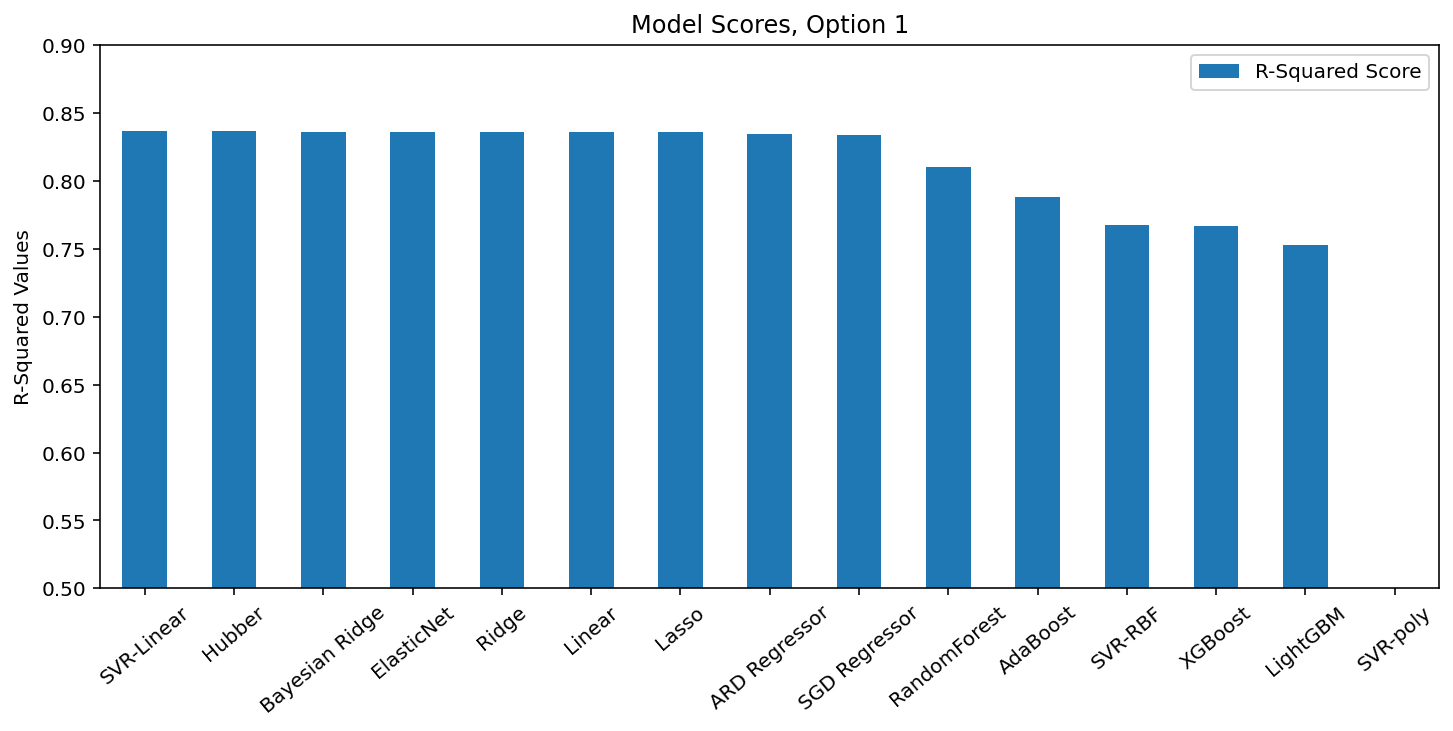

In [32]:
option = 1

df_results_option_1 = model_training(X1_train_scaled,y1_train,option)

df_results_option_1

In [33]:
# Pick a model and perform hyper-parameter tuning

model_select = BayesianRidge()

params = {'alpha_1' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'alpha_2' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_1': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_2': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'n_iter' : [100,200,300,400,500,600,700,800,900,1000]
         }

model_best1 = opt_best_model(model_select,params,X1_train_scaled,y1_train)

print()
print()

model_coeffs1 = model_best_predict(model_best1,X1_train_scaled,X1_test_scaled,y1_train,y1_test)

{'alpha_1': 0.001,
 'alpha_2': 0.001,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 0.0001,
 'lambda_2': 0.01,
 'lambda_init': None,
 'n_iter': 1000,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}
BayesianRidge(alpha_1=0.001, alpha_2=0.001, lambda_1=0.0001, lambda_2=0.01,
              n_iter=1000)


R2-Score   : 0.850993
RMSE-Train : $25,557,062.02
RMSE-Test  : $27,613,477.41


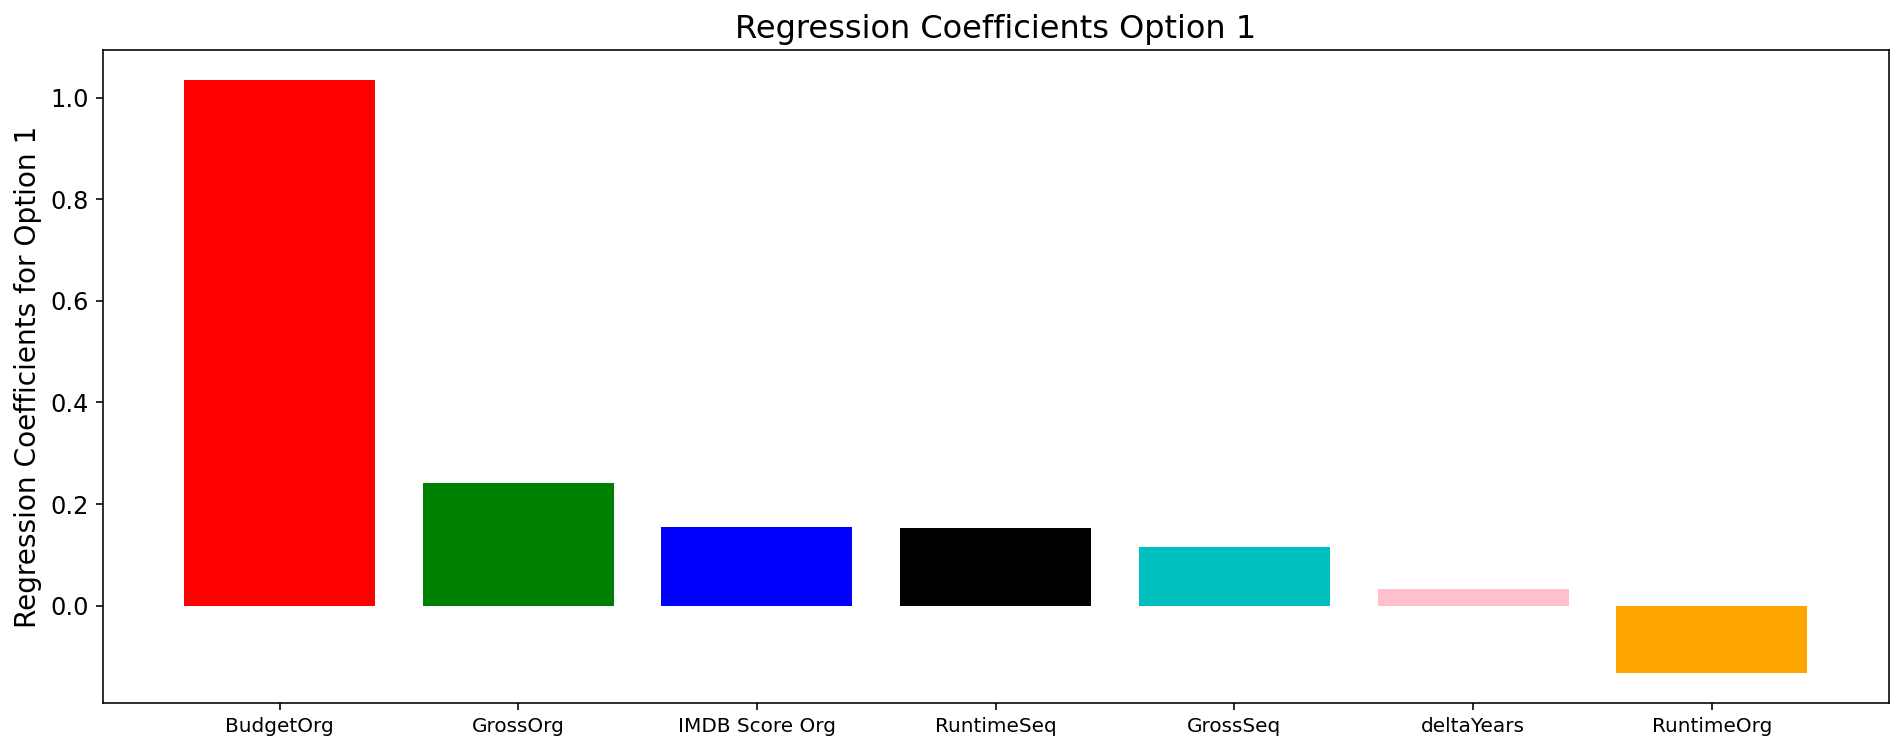

In [34]:
plot_coefficients(X1_train_scaled,model_coeffs1,1)

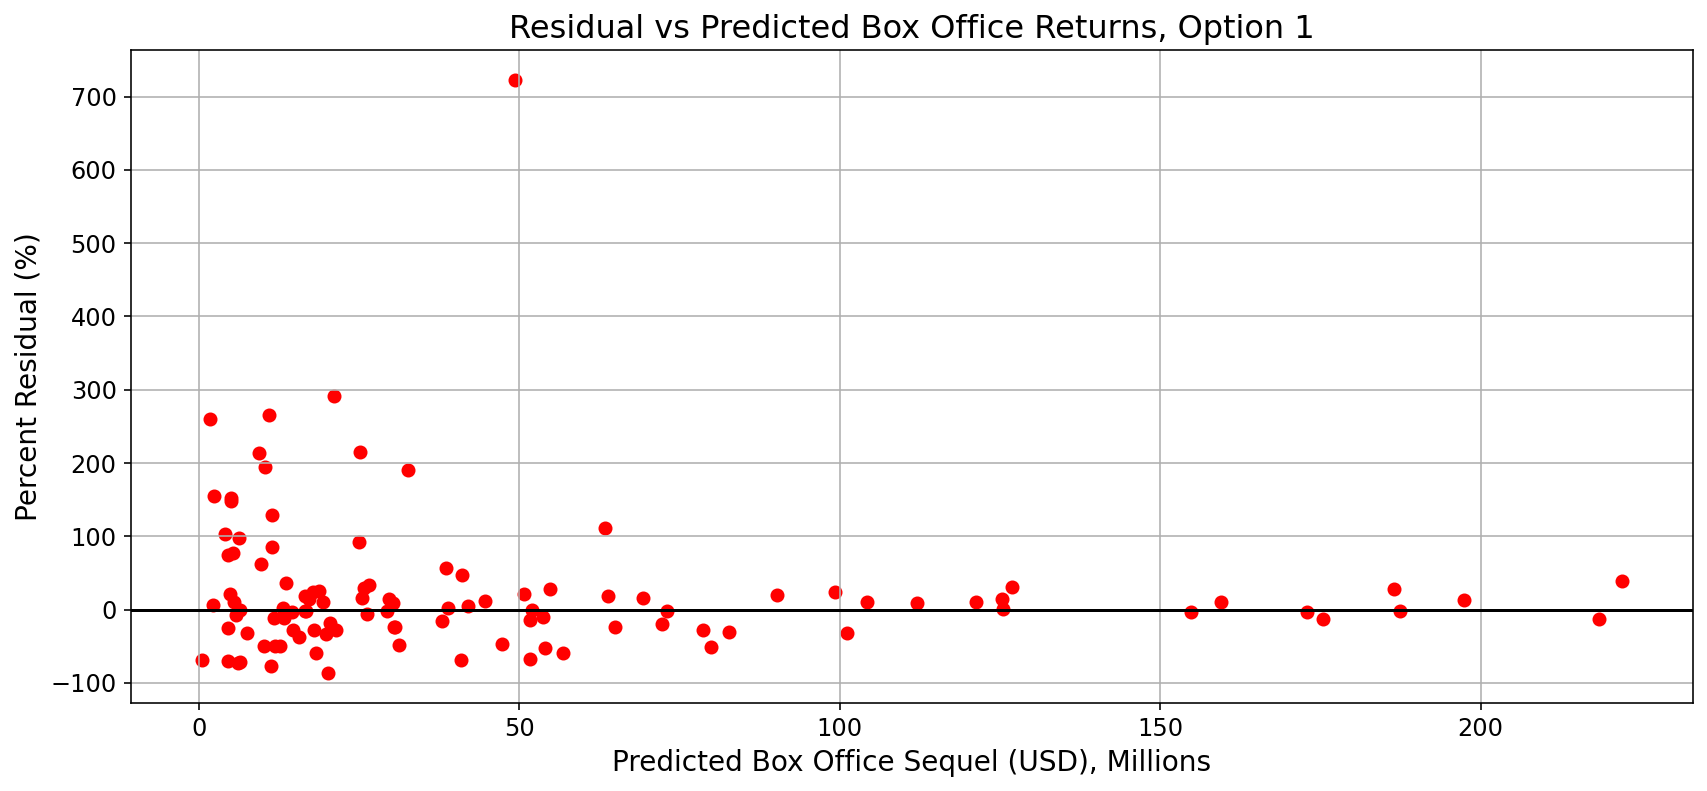

In [35]:
option = 1
zoom = 'N'

y_pred_test1 = plot_residuals(model_best1,X1_test_scaled,y1_test,zoom,1)

Overall, the framing of the question is much better in this case. 

### Modeling - Option 3

Forgoing release times. Go straight to categorical ratings instead.

In [36]:
X3 = pd.concat([X1, df_rating], axis=1)

X3.head()

,IMDB Score Org,RuntimeOrg,RuntimeSeq,deltaYears,LogBudgetOrg,LogGrossOrg,LogGrossSeq,r_G,r_PG,r_PG-13,r_R
0,7.3,121,127,2.160209,18.749984,20.530924,20.486247,0,0,1,0
1,8.7,136,138,4.123288,17.958645,19.958287,20.424653,0,0,0,1
2,8.8,178,179,0.996598,18.348110,20.604294,20.673243,0,0,1,0
3,8.9,201,169,8.994025,18.358805,20.856239,20.740126,0,0,1,0
4,7.8,161,144,1.010288,19.231611,20.680741,20.678289,0,0,1,0


In [37]:
# Do the usual train test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=test_size, random_state=1234)

In [38]:
def split_and_merge_again(X_train,X_test):

    # Now for some crazy gymnastics
    # Doing this since I want to preserve the shuffling order of the target variables
    # and to preserve the indexing
    all_cols = list(X_train.columns)

    cat_cols = []
    num_cols = []

    for col in all_cols:
    
        # Look for columns that start with r_ or g_ for ratings & genres
        cat_temp = re.findall('^[rg]_*.+',col)   # Categorical
        num_temp = re.findall('^[^rg]_*.+',col)  # Numerical
        
        if cat_temp:
            cat_cols.extend(cat_temp)
        
        if num_temp:
            num_cols.extend(num_temp)

    # Extract numerical columns
    X_train_num = X_train[num_cols]
    X_test_num = X_test[num_cols]
    
    # Extract categorical columns
    X_train_cat = X_train[cat_cols]
    X_test_cat  = X_test[cat_cols]

    # Now reset indexes
    #X_train_num = X_train_num.reset_index(drop=True)
    #X_train_cat = X_train_cat.reset_index(drop=True)

    #X_test_num = X_test_num.reset_index(drop=True)
    #X_test_cat = X_test_cat.reset_index(drop=True)
    
    # Do it for target matrix as well
    #y_train = y_train.reset_index(drop=True)
    #y_test  = y_test.reset_index(drop=True)

    # Standardize training and test data
    scx = StandardScaler()

    X_train_num_scaled = pd.DataFrame(scx.fit_transform(X_train_num),columns=X_train_num.columns,index=X_train_num.index.copy())
    X_test_num_scaled  = pd.DataFrame(scx.transform(X_test_num), columns=X_test_num.columns,index=X_test_num.index.copy())

    # Concatenate with numerical and categorical data
    X_train_scaled = pd.concat([X_train_num_scaled, X_train_cat], axis=1)
    X_test_scaled = pd.concat([X_test_num_scaled, X_test_cat], axis=1)
    
    return X_train_scaled,X_test_scaled

In [39]:
X3_train_scaled,X3_test_scaled = split_and_merge_again(X3_train,X3_test)


,R-Squared Score
SVR-Linear,0.836542
Hubber,0.836117
Bayesian Ridge,0.835353
ElasticNet,0.835185
Ridge,0.835151
Linear,0.835151
Lasso,0.835137
ARD Regressor,0.834122
RandomForest,0.808004
AdaBoost,0.788246


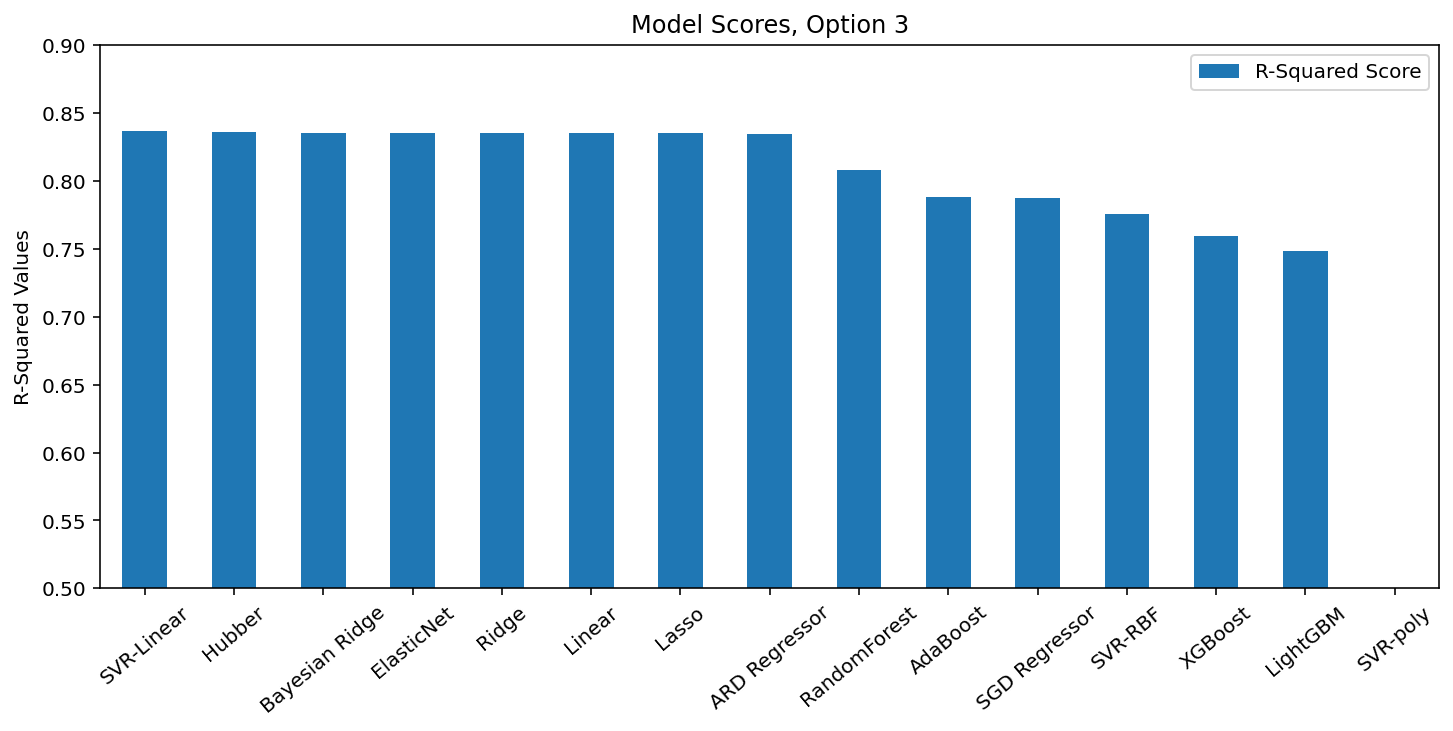

In [40]:
df_results_option_3 = model_training(X3_train_scaled,y3_train,3)

df_results_option_3

In [41]:
model_select = BayesianRidge()

params = {'alpha_1' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'alpha_2' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_1': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_2': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'n_iter' : [100,200,300,400,500,600,700]
         }

model_best3 = opt_best_model(model_select,params,X3_train_scaled,y3_train)

{'alpha_1': 0.0001,
 'alpha_2': 0.0001,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 0.1,
 'lambda_2': 1e-07,
 'lambda_init': None,
 'n_iter': 200,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}
BayesianRidge(alpha_1=0.0001, alpha_2=0.0001, lambda_1=0.1, lambda_2=1e-07,
              n_iter=200)


In [42]:
model_coeffs3 = model_best_predict(model_best3,X3_train_scaled,X3_test_scaled,y3_train,y3_test)

R2-Score   : 0.851363
RMSE-Train : $25,765,512.72
RMSE-Test  : $27,705,229.45


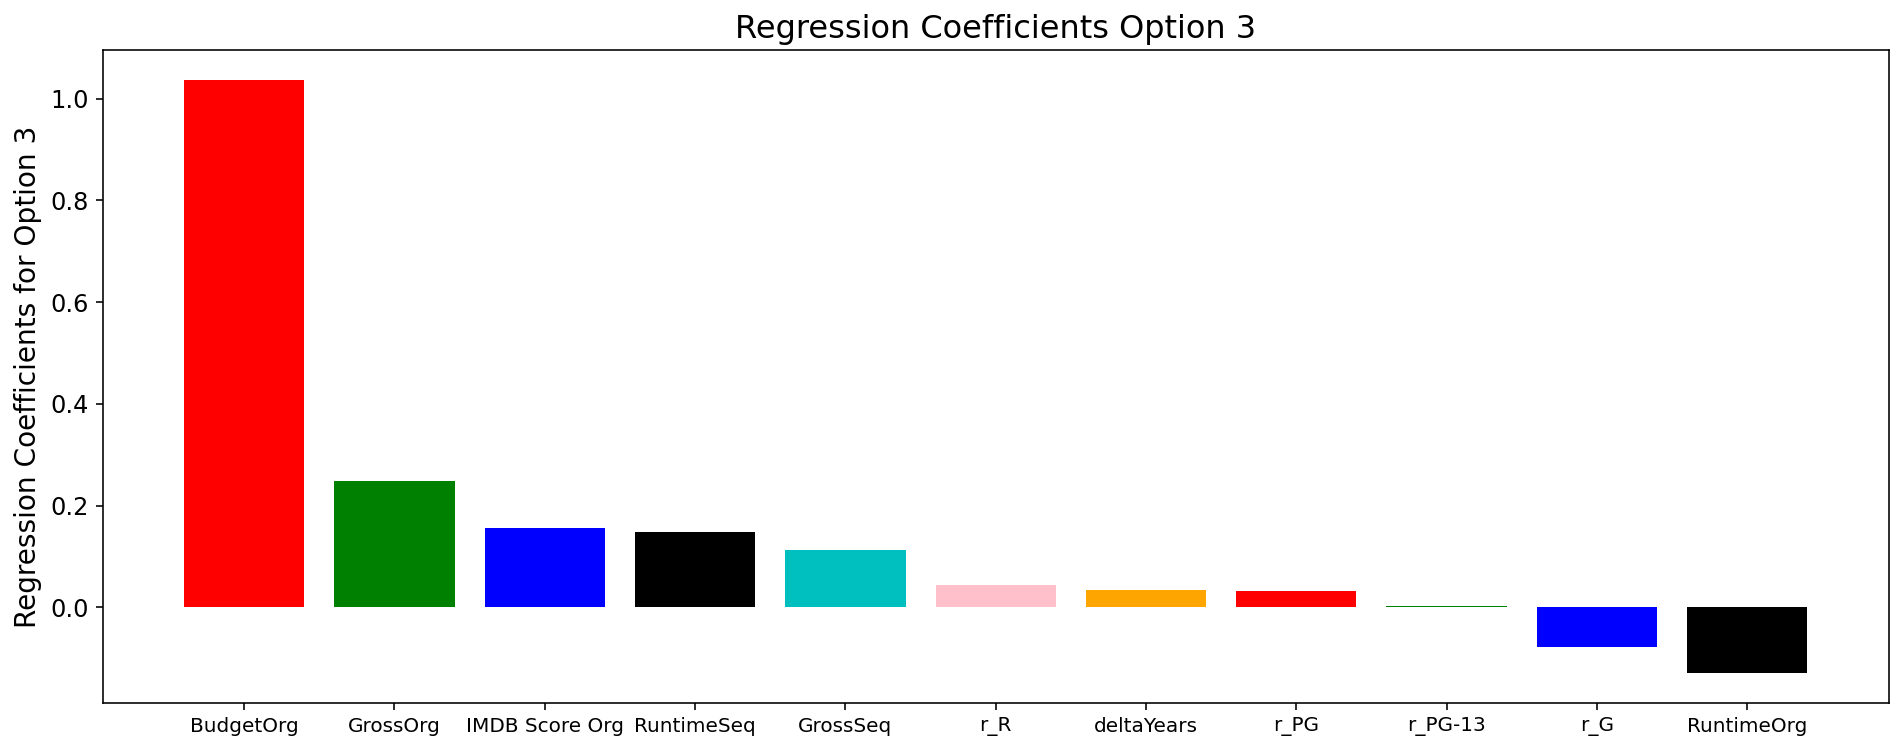

In [43]:
option = 3

plot_coefficients(X3_train,model_coeffs3,option)

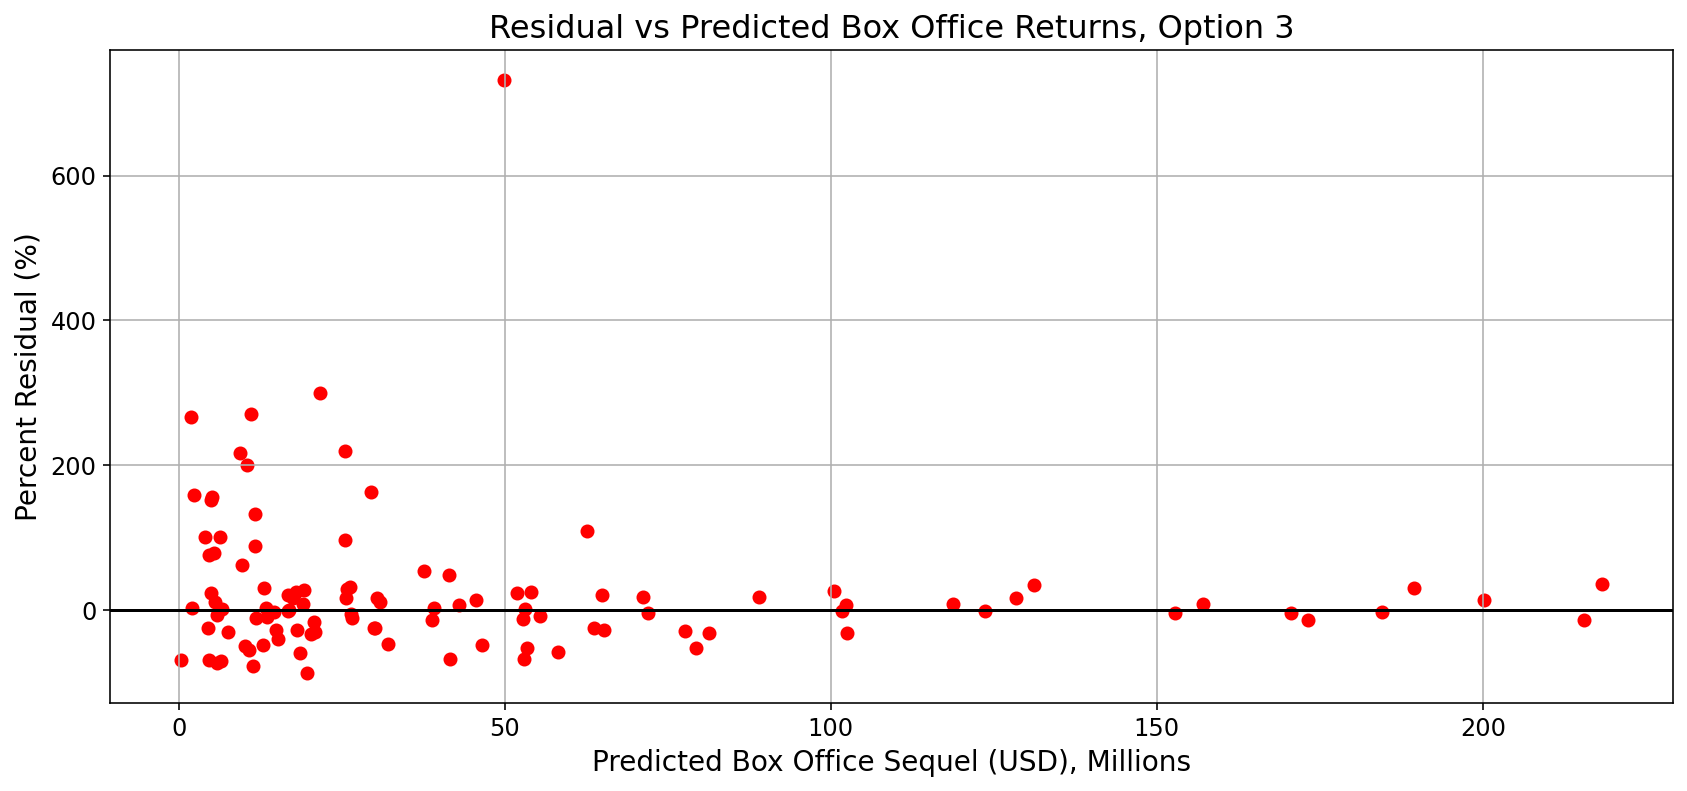

In [44]:
#option = 2
zoom = 'N'

y_pred3 = plot_residuals(model_best3,X3_test_scaled,y3_test,zoom,option)

In [45]:
for i,v in enumerate(y3_test):
    if (np.exp(v) > 50000000 and np.exp(v) < 52000000):
        print(i,np.exp(v))

60 51999999.99999996


### Modeling - Option 4

In [46]:
X4 = pd.concat([X3, df_genres], axis=1)

X4.head()

,IMDB Score Org,RuntimeOrg,RuntimeSeq,deltaYears,LogBudgetOrg,LogGrossOrg,LogGrossSeq,r_G,r_PG,r_PG-13,...,g_Horror,g_Music,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Sport,g_Thriller,g_War,g_Western
0,7.3,121,127,2.160209,18.749984,20.530924,20.486247,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,8.7,136,138,4.123288,17.958645,19.958287,20.424653,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,8.8,178,179,0.996598,18.348110,20.604294,20.673243,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,8.9,201,169,8.994025,18.358805,20.856239,20.740126,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,7.8,161,144,1.010288,19.231611,20.680741,20.678289,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Train-test split for Option 4
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=test_size, random_state=1234)

X4_train_scaled,X4_test_scaled = split_and_merge_again(X4_train,X4_test)


,R-Squared Score
ARD Regressor,0.829720
Bayesian Ridge,0.827760
SVR-Linear,0.825812
Hubber,0.825631
Lasso,0.825123
ElasticNet,0.823899
Ridge,0.821624
Linear,0.821620
RandomForest,0.809882
SVR-RBF,0.787017


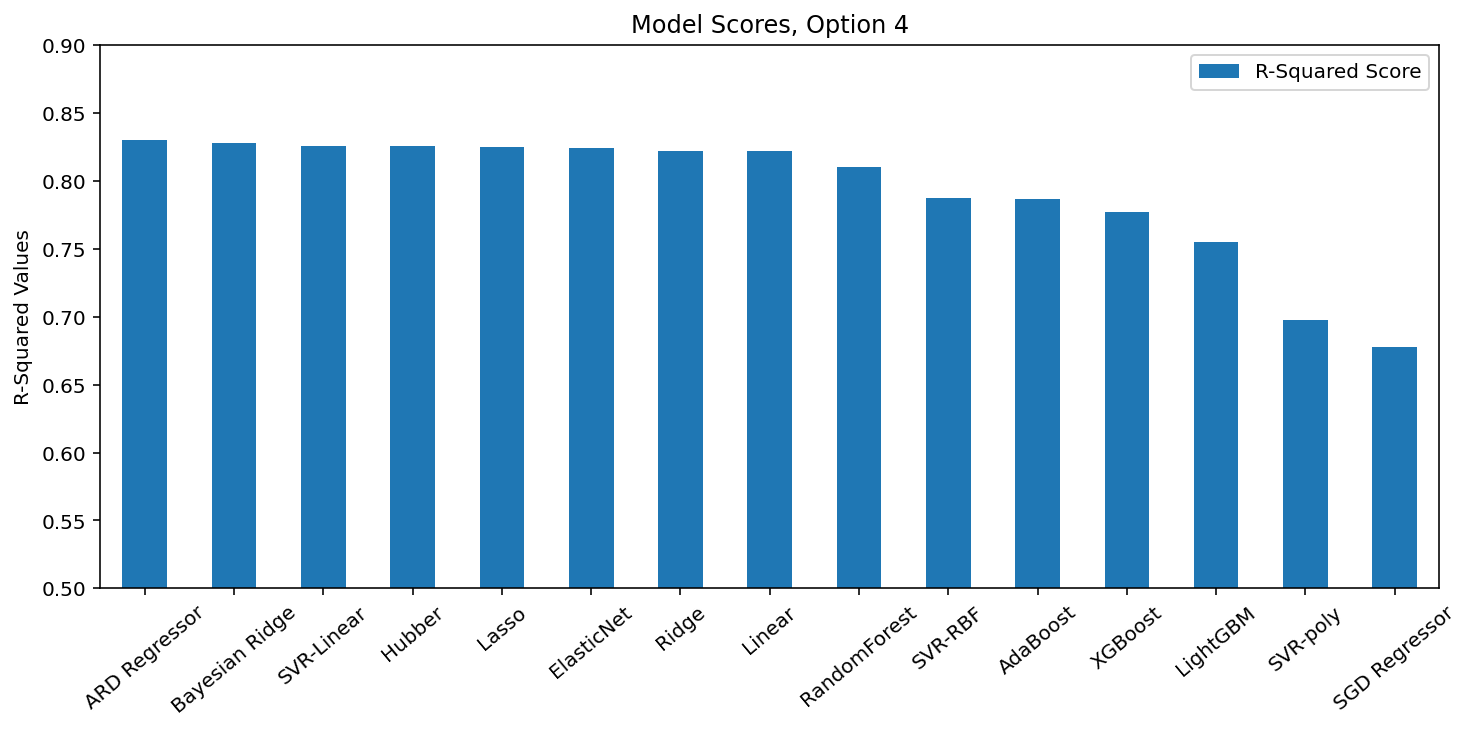

In [48]:
option = 4

df_results_option_4 = model_training(X4_train_scaled,y4_train,option)

df_results_option_4

In [49]:
model_select = BayesianRidge()

params = {'alpha_1' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'alpha_2' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_1': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'lambda_2': [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0,0.1,0.2,0.3],
          'fit_intercept' : [False,True],
          'n_iter' : [100,200,300,400,500,600,700,800,900,1000]
         }

model_best4 = opt_best_model(model_select,params,X4_train_scaled,y4_train)

{'alpha_1': 0,
 'alpha_2': 0.0001,
 'alpha_init': None,
 'compute_score': False,
 'copy_X': True,
 'fit_intercept': True,
 'lambda_1': 0.01,
 'lambda_2': 0,
 'lambda_init': None,
 'n_iter': 100,
 'normalize': False,
 'tol': 0.001,
 'verbose': False}
BayesianRidge(alpha_1=0, alpha_2=0.0001, lambda_1=0.01, lambda_2=0, n_iter=100)


In [50]:
model_coeffs4 = model_best_predict(model_best4,X4_train_scaled,X4_test_scaled,y4_train,y4_test)

R2-Score   : 0.859203
RMSE-Train : $26,614,378.22
RMSE-Test  : $27,687,767.68


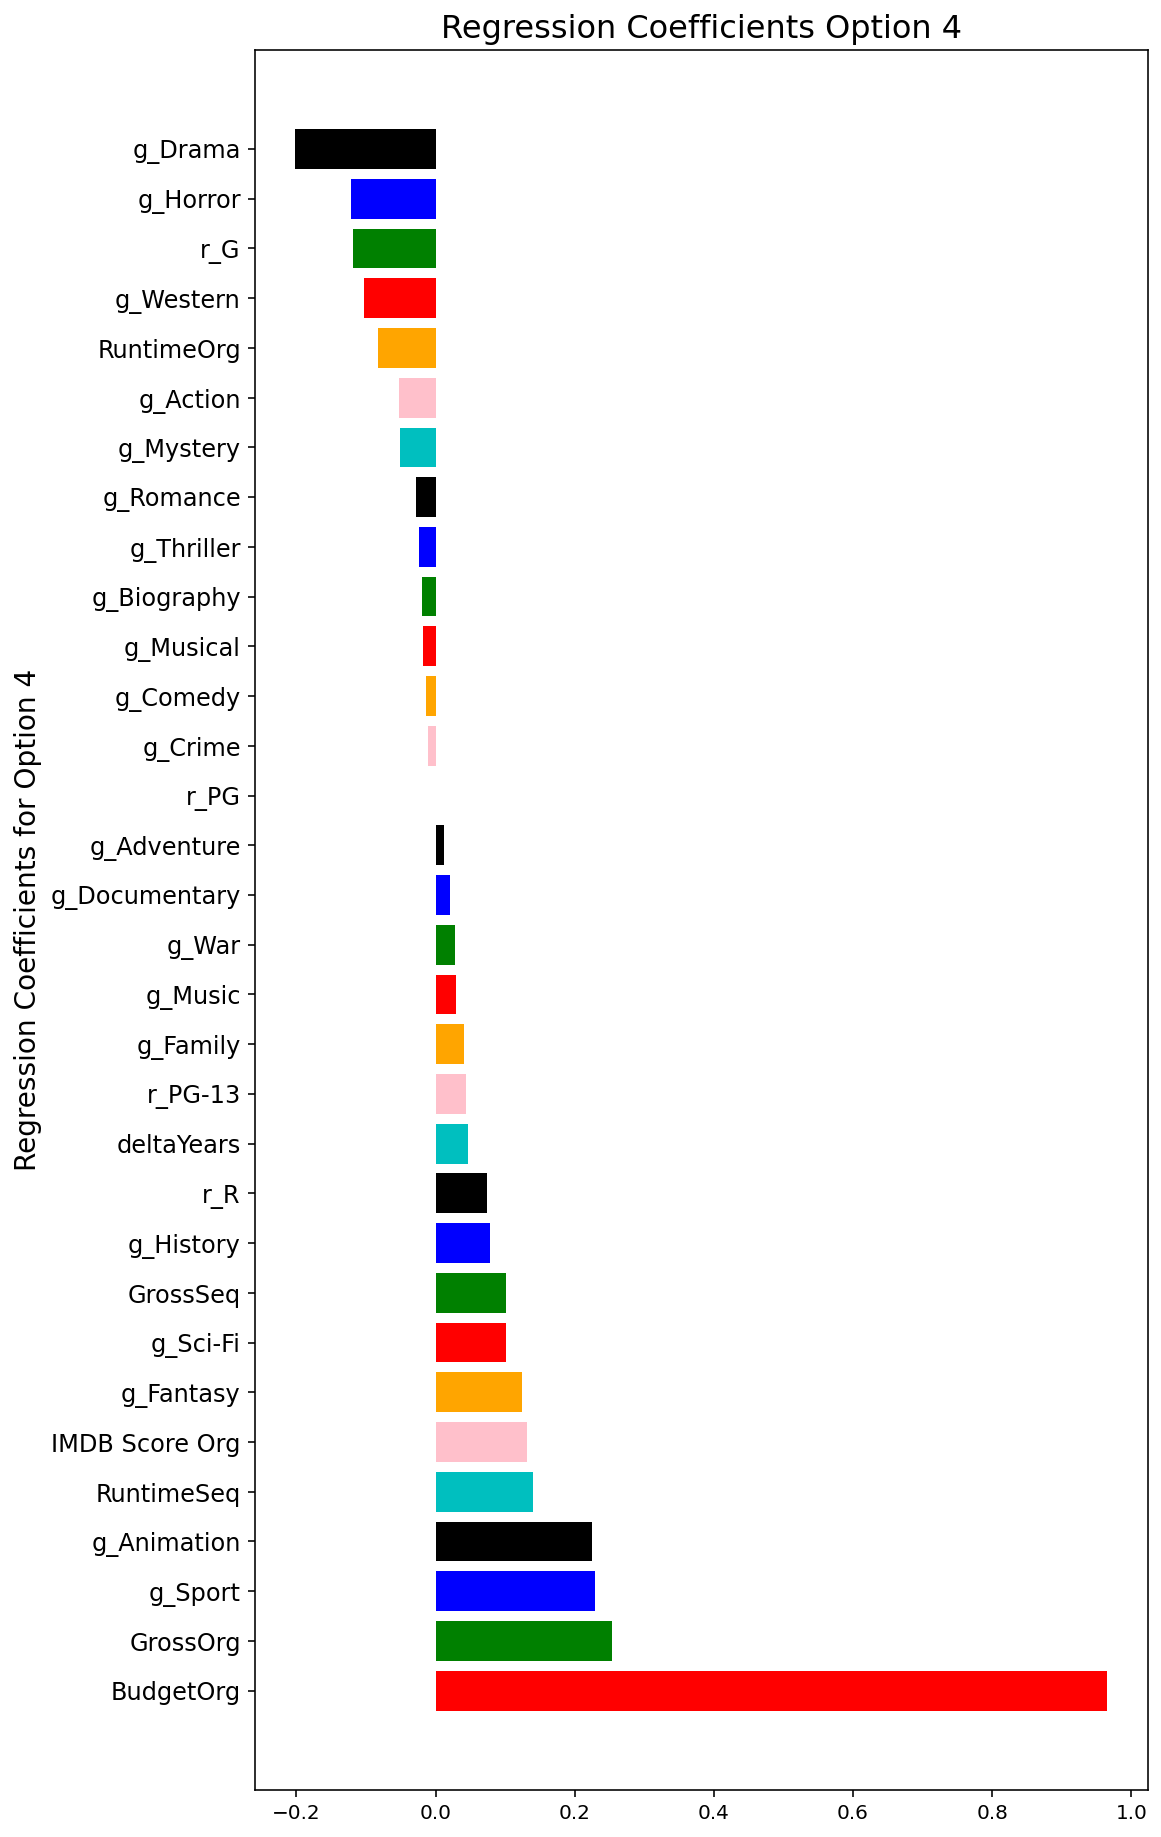

In [51]:
option = 4

plot_coefficients(X4_train,model_coeffs4,option,'h')

In [52]:
def ols_statsmodels(X,y):
    
    model_ols = sm.OLS(y, sm.add_constant(X)).fit()
    
    model_ols.summary()
    
    return(model_ols)

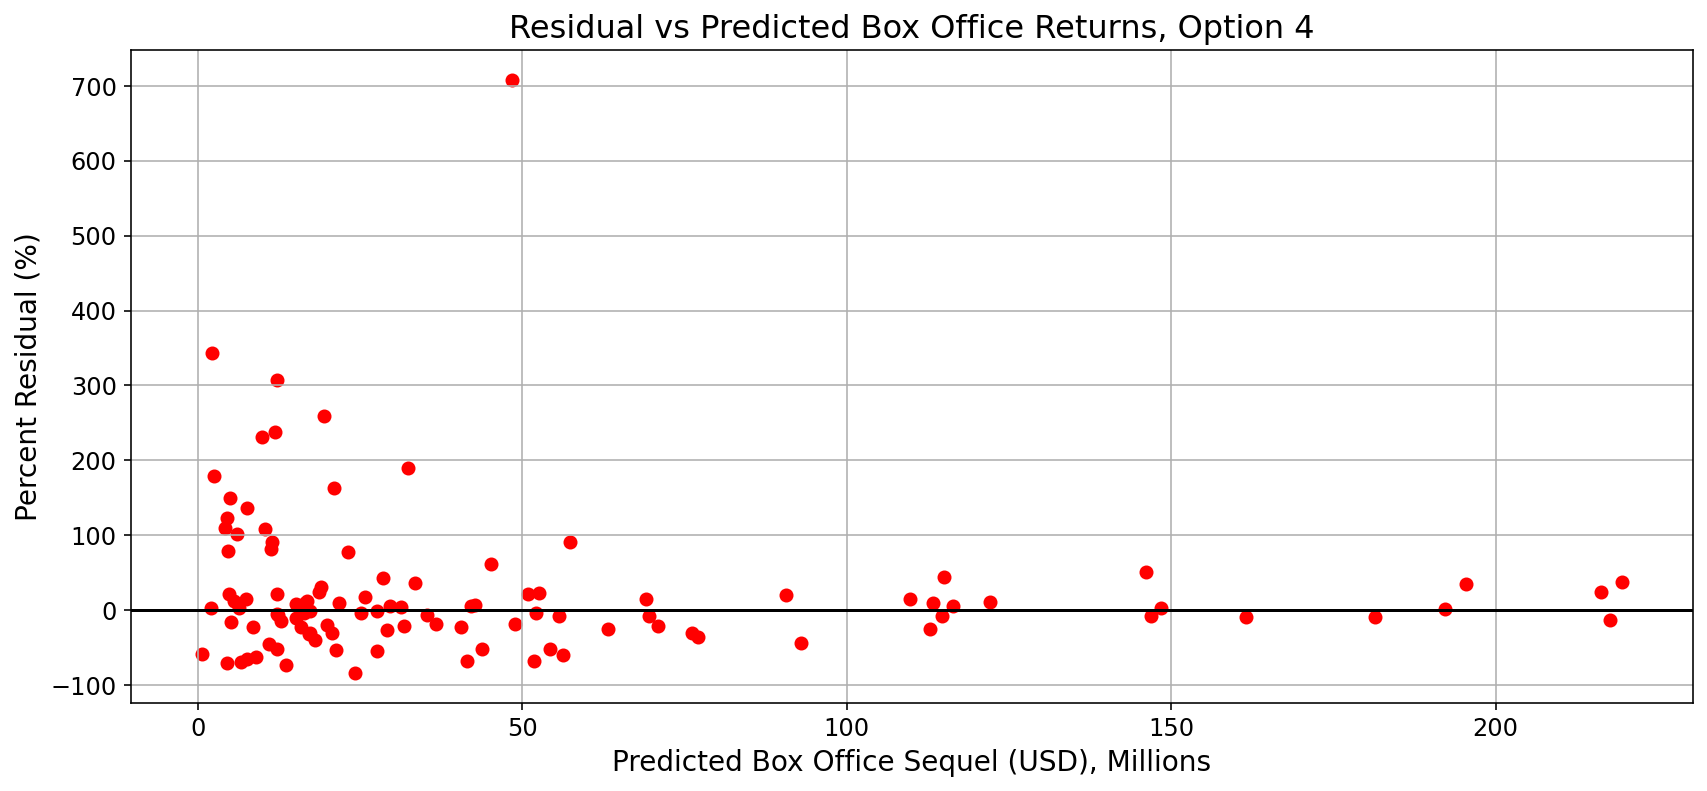

In [53]:
option = 4
zoom = 'N'

y_pred4 = plot_residuals(model_best4,X4_test_scaled,y4_test,zoom,option)

## Modeling with Statsmodel

Get a little more extra details with StatsModels OLS

### Modeling sm.OLS - Option 1

In [58]:
# Add intercept for OLS

model_ols1 = sm.OLS(y1_train, sm.add_constant(X1_train_scaled)).fit()

model_ols1.summary()

#model_ols1 = ols_statsmodels(X1_train_scaled,y1_train)

#model_ols1.summary()

#X1_train_scaled.info()
#y1_train.index

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     339.5
Date:                Sun, 01 Nov 2020   Prob (F-statistic):          1.33e-167
Time:                        21:47:15   Log-Likelihood:                -345.16
No. Observations:                 424   AIC:                             706.3
Df Residuals:                     416   BIC:                             738.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.0361      0.027    636.225      0.000      16.983      17.089
IMDB Score Org     0.1581      0.031      5.054      0.000       0.097       0.220
RuntimeOrg        -0.1374      0.044     -3.135      0.002      -0.224      -0.051
RuntimeSeq         0.1544      0.044      3.493      0.001       0.068       0.241
deltaYears         0.0327      0.027      1.203      0.229      -0.021       0.086
LogBudgetOrg       1.0440      0.042     24.783      0.000       0.961       1.127
LogGrossOrg        0.2378      0.042      5.726      0.000       0.156       0.319
LogGrossSeq        0.1132      0.033      3.448      0.001       0.049       0.178
==============================================================================
Omnibus:                       29.325   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.294
Skew:                          -0.183   Prob(JB):                     1.23e-21
Kurtosis:                       5.306   Cond. No.                         3.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
X1_train_scaled.drop(['deltaYears'],axis=1,inplace=True)

In [60]:
model_ols1x = ols_statsmodels(X1_train_scaled,y1_train)

model_ols1x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     395.4
Date:                Sun, 01 Nov 2020   Prob (F-statistic):          1.32e-168
Time:                        21:47:29   Log-Likelihood:                -345.90
No. Observations:                 424   AIC:                             705.8
Df Residuals:                     417   BIC:                             734.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.0361      0.027    635.884      0.000      16.983      17.089
IMDB Score Org     0.1597      0.031      5.109      0.000       0.098       0.221
RuntimeOrg        -0.1426      0.044     -3.267      0.001      -0.228      -0.057
RuntimeSeq         0.1611      0.044      3.673      0.000       0.075       0.247
LogBudgetOrg       1.0479      0.042     24.936      0.000       0.965       1.131
LogGrossOrg        0.2323      0.041      5.625      0.000       0.151       0.314
LogGrossSeq        0.1132      0.033      3.447      0.001       0.049       0.178
==============================================================================
Omnibus:                       27.545   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.060
Skew:                          -0.149   Prob(JB):                     4.58e-20
Kurtosis:                       5.225   Cond. No.                         3.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
model_ols4 = ols_statsmodels(X4_train_scaled,y4_train)

model_ols4.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     77.83
Date:                Sun, 01 Nov 2020   Prob (F-statistic):          3.25e-147
Time:                        21:47:47   Log-Likelihood:                -331.62
No. Observations:                 424   AIC:                             727.2
Df Residuals:                     392   BIC:                             856.8
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             13.6152      0.118    115.224      0.000      13.383      13.848
IMDB Score Org     0.1378      0.034      4.103      0.000       0.072       0.204
RuntimeOrg        -0.0904      0.049     -1.857      0.064      -0.186       0.005
RuntimeSeq         0.1517      0.046      3.266      0.001       0.060       0.243
deltaYears         0.0460      0.028      1.645      0.101      -0.009       0.101
LogBudgetOrg       0.9873      0.049     20.130      0.000       0.891       1.084
LogGrossOrg        0.2435      0.043      5.669      0.000       0.159       0.328
LogGrossSeq        0.0911      0.035      2.609      0.009       0.022       0.160
r_G                3.2422      0.137     23.599      0.000       2.972       3.512
r_PG               3.4101      0.071     48.361      0.000       3.272       3.549
r_PG-13            3.4609      0.067     51.964      0.000       3.330       3.592
r_R                3.5020      0.061     57.876      0.000       3.383       3.621
g_Action          -0.0507      0.084     -0.605      0.545      -0.215       0.114
g_Adventure        0.0070      0.085      0.083      0.934      -0.159       0.174
g_Animation        0.3074      0.148      2.075      0.039       0.016       0.599
g_Biography       -0.1989      0.341     -0.583      0.560      -0.870       0.472
g_Comedy          -0.0064      0.094     -0.069      0.945      -0.191       0.178
g_Crime            0.0013      0.092      0.014      0.989      -0.179       0.181
g_Documentary      0.1428      0.560      0.255      0.799      -0.959       1.245
g_Drama           -0.2124      0.086     -2.459      0.014      -0.382      -0.043
g_Family           0.0629      0.115      0.546      0.585      -0.163       0.289
g_Fantasy          0.1552      0.099      1.573      0.117      -0.039       0.349
g_History          0.6923      0.648      1.068      0.286      -0.582       1.967
g_Horror          -0.1155      0.107     -1.079      0.281      -0.326       0.095
g_Music            0.0913      0.304      0.300      0.764      -0.506       0.689
g_Musical         -0.0959      0.577     -0.166      0.868      -1.231       1.039
g_Mystery         -0.0414      0.103     -0.402      0.688      -0.244       0.161
g_Romance         -0.0183      0.126     -0.145      0.885      -0.267       0.230
g_Sci-Fi           0.1226      0.097      1.269      0.205      -0.067       0.313
g_Sport            0.3786      0.193      1.966      0.050   -6.86e-06       0.757
g_Thriller        -0.0195      0.087     -0.224      0.823      -0.191       0.152
g_War              0.1886      0.563      0.335      0.738      -0.918       1.295
g_Western         -0.2398      0.337     -0.712      0.477      -0.902       0.422
==============================================================================
Omnibus:        

In [ ]:
#sm.OLS(endog = y3_train, exog = sm.add_constant(X3_train)).fit()  #endog = Y, exog = X_opt